# Compliance Dashboard Notebook

#### ver 190102

In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import math
from scipy import optimize
from scipy.optimize import least_squares
import time

import sys
def printf(format, *args):
    sys.stdout.write(format % args)
    
#from bokeh.plotting import figure,show
#from bokeh.io import output_notebook
#output_notebook()

#import matplotlib.widgets


## Load in the vc modules

In [2]:
os.chdir('/home/rbussell/vcproc/')
sys.path.append('/home/rbussell/lib/')
import vc
from vc.view import *
from vc.load import *
from vc.calccomp import *

## Data Conventions

In [3]:
nX=64;nY=64;nSlices=14;nReps=78;nTIs=7
tiArr=np.arange(250,950,100)
idxTagStart=0;idxCtrStart=1

### Specifics of this data set

In [4]:
!ls data/subname_vccloud/

119_180612  fitMask.nii.gz  fitMask.npy  PhysMon  subject_info.txt  vremoteproc


In [5]:
#id_dir='119_180612_vccloud'
#~/data/compliance/kbcda/KBCDA_403_Q4Y18
#id_dir='403_181212'
#subDir='/home/rbussell/data/vcprocRemote/KBCDA_403_Q4Y18_vccloud'
#id_dir='3696_181219'
#subDir='/home/rbussell/data/vcprocRemote/KBCDA_3696_Q4Y18_vccloud'
#id_dir='002_180524'
#subDir='/home/rbussell/data/vcprocRemote/180524_01A_vccloud'
id_dir='002_180525'
subDir='/home/rbussell/data/vcprocRemote/180525_02A_vccloud'
#id_dir='119_180612'
#subDir='/home/rbussell/data/vcprocRemote/subname_vccloud'
M0=40;
alpha=1;
#fsWide=(40,10)

### Read the data and the mask

In [6]:
picoreMat=np.zeros((nX,nY,nSlices,nReps,nTIs))
picoreMat=VC_loadPicoreData(subDir, id_dir,verbosity=0)
phiCSMat=VC_loadPhiCS(subDir,id_dir,verbosity=0)
picoreMat=np.transpose(picoreMat,(1,0,2,3,4))

maskFn=subDir+'/fitMask.npy';
mask=np.transpose(np.load(maskFn),(1,0,2))

picoreMat=np.tile(mask[:,:,:,np.newaxis,np.newaxis],(1,1,1,78,7))*picoreMat

### Prepare tag control combinations for fitting

In [7]:
deltaMat=picoreMat[:,:,:,idxCtrStart::2,:]-picoreMat[:,:,:,idxTagStart::2,:]
mTag=picoreMat[:,:,:,idxTagStart::2,:]
mCtr=picoreMat[:,:,:,idxCtrStart::2,:]
mCtrAve=np.mean(mCtr,3)
mTagMCtrAve=np.tile(np.reshape(mCtrAve,(nX,nY,nSlices,1,nTIs)),(1,1,1,int(nReps/2),1))-mTag
print('Input picore matrix shapes: \nmCtr: '+ str(np.shape(mCtr))+'\nmTag: '+ str(np.shape(mTag))+'\nmTagMCtrAve: '+ str((np.shape(mTagMCtrAve))))

Input picore matrix shapes: 
mCtr: (64, 64, 14, 39, 7)
mTag: (64, 64, 14, 39, 7)
mTagMCtrAve: (64, 64, 14, 39, 7)


### Read in some single voxel vectors

(273,)

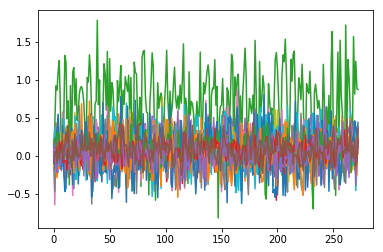

In [8]:
x=30;y=30;z=3
mTagMCtrAveVec=np.reshape(mTagMCtrAve,(nX,nY,nSlices,int(nTIs*nReps/2)))[x,y,z,:]
mTagVec=np.reshape(mTag,(nX,nY,nSlices,int(nTIs*nReps/2)))
mCtrVec=np.reshape(mCtr,(nX,nY,nSlices,int(nTIs*nReps/2)))

plt.figure()
for x in np.arange(24,40,4):
    for y in np.arange(24,40,4):
        z=4
        deltaMSeqVec=mCtrVec[x,y,z,:]-mTagVec[x,y,z,:]
        plt.plot(deltaMSeqVec)
#plt.title('selected $\Delta M$')
np.shape(deltaMSeqVec)

In [9]:
!ls data/subname_vccloud/fitMask.npy

data/subname_vccloud/fitMask.npy


## Calculate a fractional signal change CBF map $\Delta M/M_{ave}$

/home/rbussell/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


(64, 64, 14, 7)


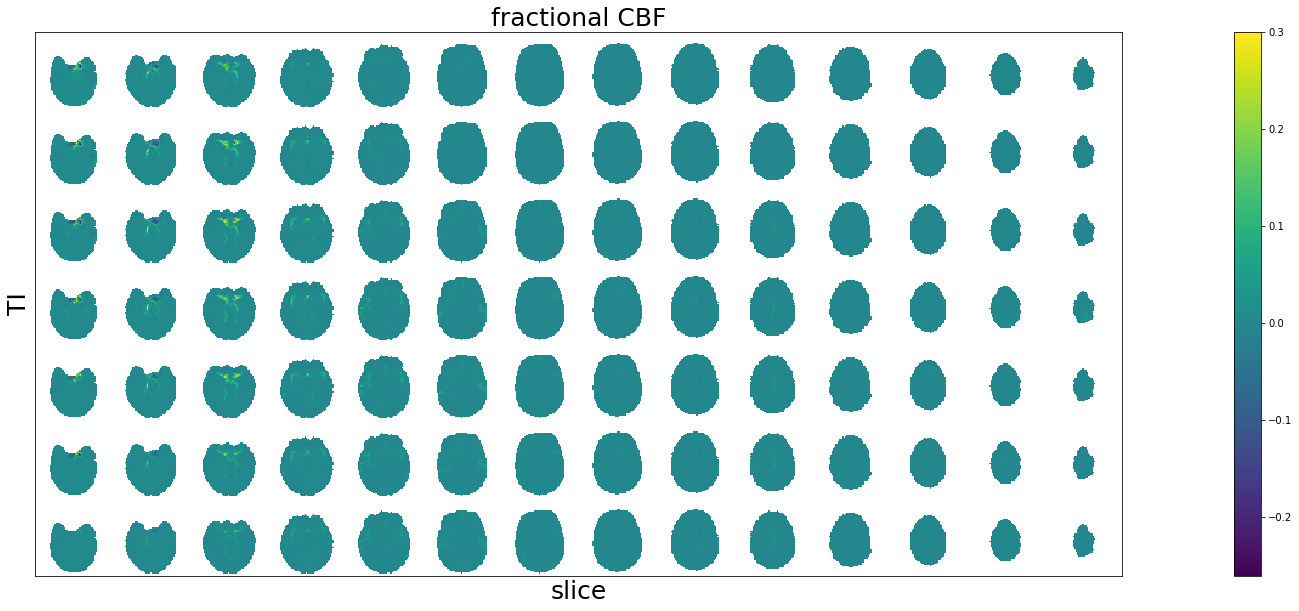

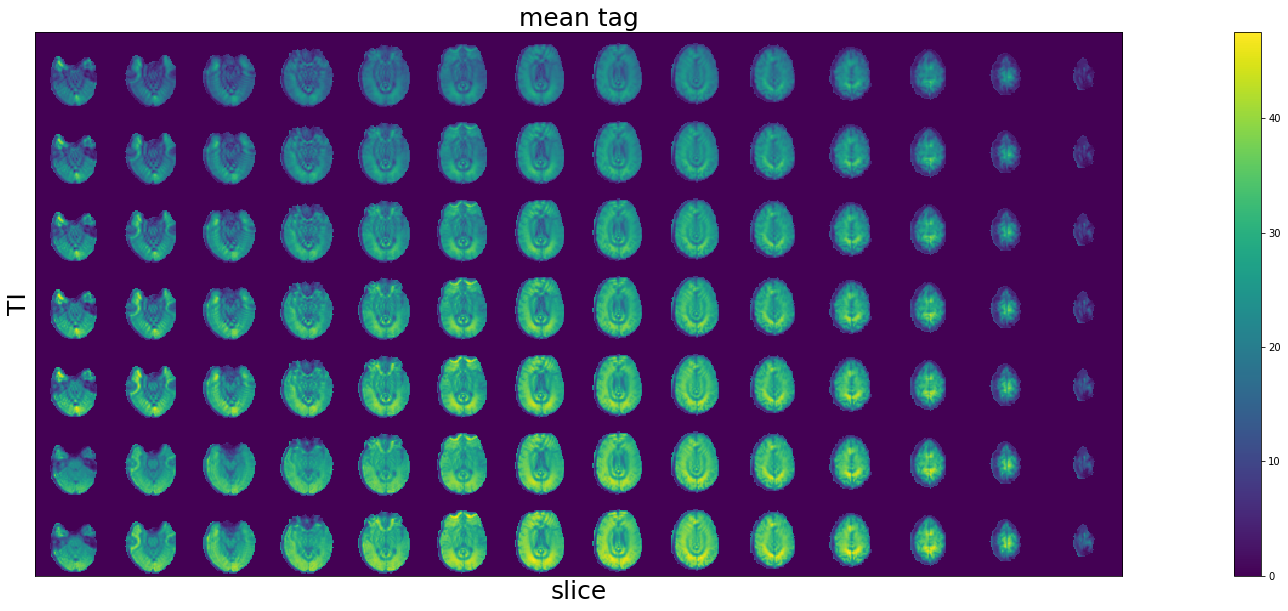

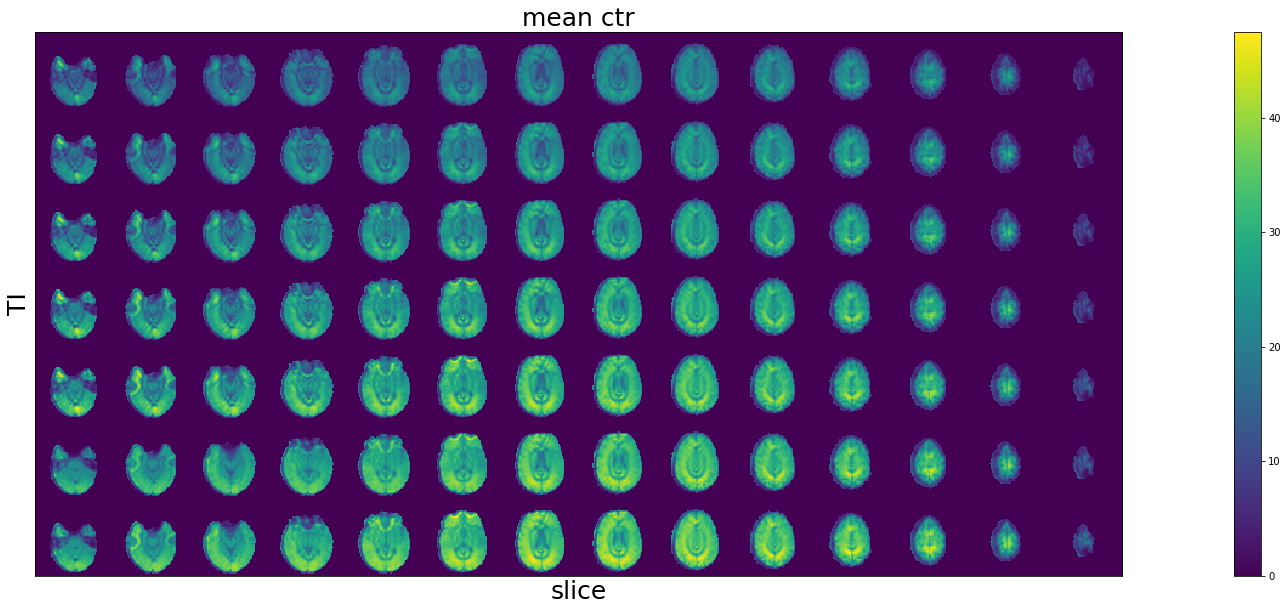

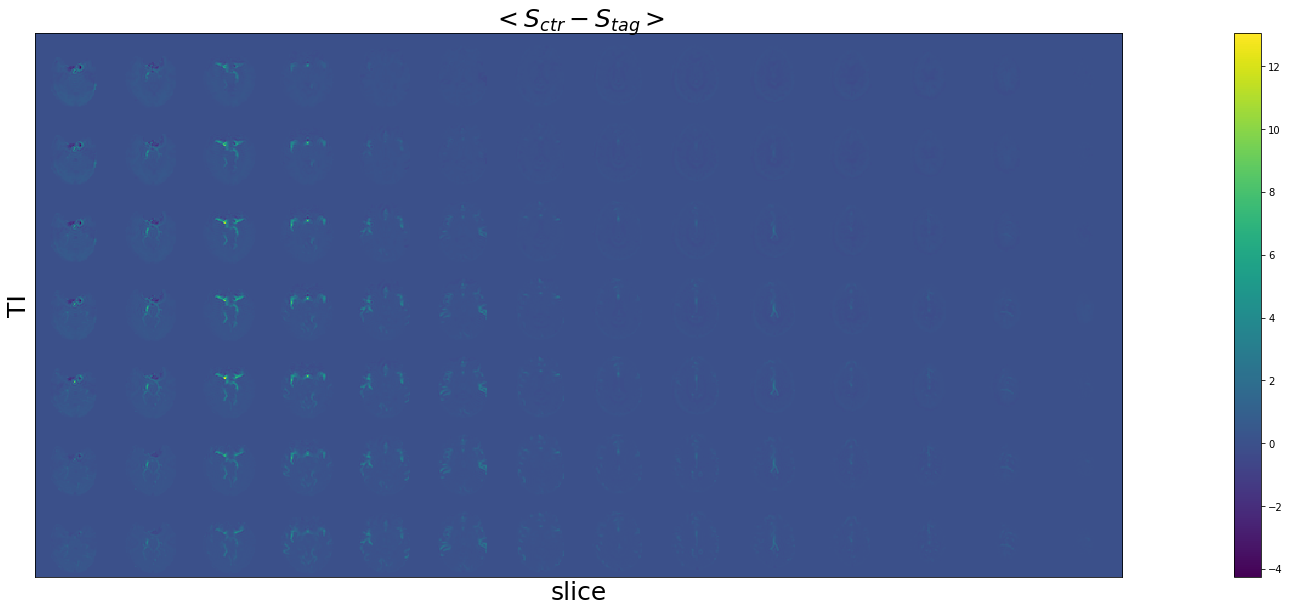

/home/rbussell/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/home/rbussell/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log


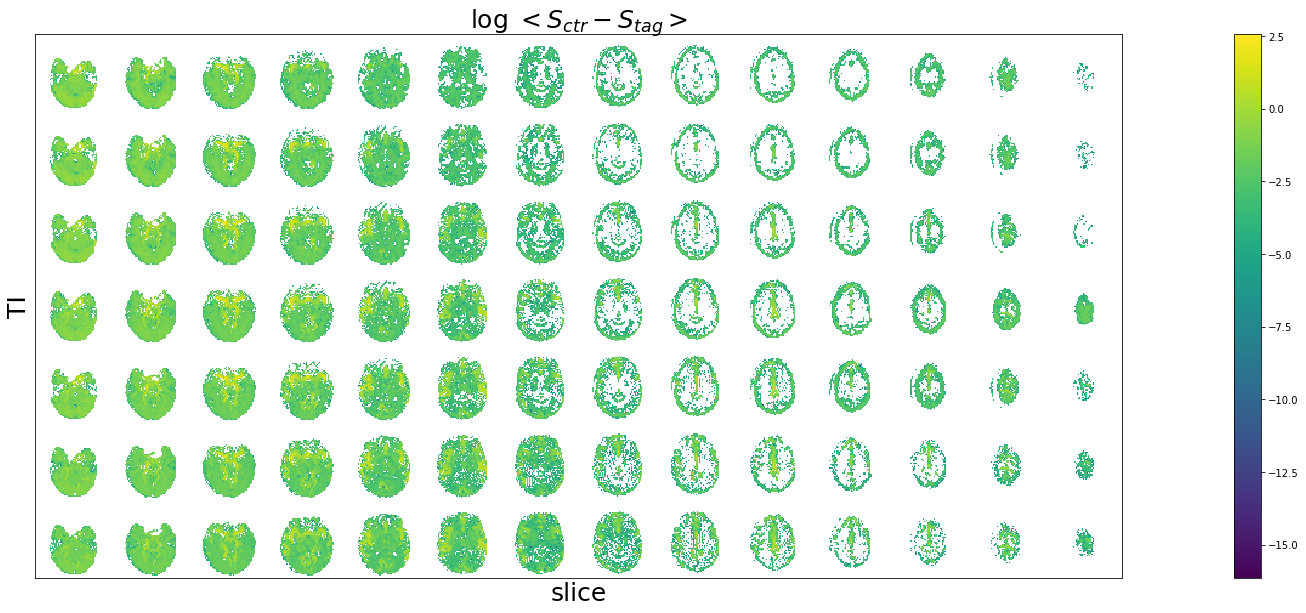

In [10]:
cbfMap=np.mean(np.mean(deltaMat,3),3)
fracCbfMap=np.mean((mCtr-mTag)/(mCtr+mTag),3)
print(np.shape(fracCbfMap))

#plotOnePlane(fracCbfMap[:,:,4,0],cmap='viridis')

sliceDataMontage(fracCbfMap,dispFlag=1,title='fractional CBF',xLab='slice',yLab='TI',txtsz=25)
sliceDataMontage(np.mean(mTag,3),dispFlag=1,title='mean tag',xLab='slice',yLab='TI',txtsz=25)
sliceDataMontage(np.mean(mCtr,3),dispFlag=1,title='mean ctr',xLab='slice',yLab='TI',txtsz=25)
sliceDataMontage(np.mean(mCtr-mTag,3),dispFlag=1,title='$<S_{ctr}-S_{tag}>$',xLab='slice',yLab='TI',txtsz=25)

#sliceDataMontage(np.mean(mCtr-mTag,3),dispFlag=1,title='$<S_{ctr}-S_{tag}>$',xLab='slice',yLab='TI',txtsz=25,cmap='viridis')
sliceDataMontage(np.log(np.mean(mCtr-mTag,3)),dispFlag=1,title='log $<S_{ctr}-S_{tag}>$',xLab='slice',yLab='TI',txtsz=25,cmap='viridis')

## Do some QA on the physio data

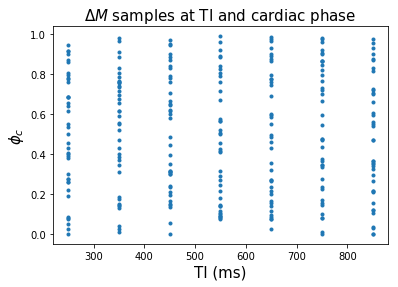

In [11]:
#Get the phiCS for this slice
#print('phiCSMat shape: ', np.shape(phiCSMat))
phiCS=phiCSMat[(z-1)::nSlices,:] #select a slice (incl. t and c, and TI)
phiCSTag=phiCS[idxTagStart::2,:] #now only take tags for this slice

#vectorize the inputs
phiCSVec=np.reshape(phiCSTag,(273,))
tiVec=np.reshape(np.tile(tiArr,(39,1)),(273,))

dataVec=mTagMCtrAveVec

plt.plot(tiVec,phiCSVec,'.');
plt.title('$\Delta M$ samples at TI and cardiac phase',fontsize=15);
plt.xlabel('TI (ms)',fontsize=15);
plt.ylabel('$\phi_c$',fontsize=15)
plt.show()

### Missing: Display the raw physio data

In [12]:
def globalOtsuMaskLocal(image):
    from skimage.filters import threshold_otsu

    global_thresh = threshold_otsu(image)
    binary_global = abvMinMat > global_thresh
    
    return binary_global

def dilateMaskLocal(mask,nDilations):
    from scipy import ndimage
    cnt=0
    while cnt < nDilations:
        cnt=cnt+1
        mask=ndimage.binary_dilation(mask)
    return mask

def plotCompPanelLocal(compMat,abvMaxMat,abvMinMat,abvMaxIdxMat,abvMinIdxMat,mseMat,nPhases=100,abvMinVal=0.0,abvMaxVal=2,compMaxVal=1,compMinVal=0,cbfMap=cbfMap):
    import pylab
    cmapComp='viridis'
    cmapDisc = pylab.cm.get_cmap('PiYG', nPhases)
    cbfMinVal=0.2;cbfMaxVal=1.0
    print('plotCompPanel got cbfMat size', np.shape(cbfMap))
    h=plt.figure(figsize=(20,20))
    h.subplots_adjust(hspace=0.2,wspace=0.3)
    plt.subplot(442)
    plt.title('$max(abv(\phi_c^s))$',fontsize=20)
    plt.imshow(np.log10(abvMaxMat),vmin=-3,vmax=-1,cmap='viridis',interpolation='none');
    cbar = plt.colorbar();cbar.set_label('$log_{10}(mL/mL)$')

    plt.subplot(443)
    plt.title('$min(abv(\phi_c^s))$',fontsize=20)
    plt.imshow(np.log10(abvMinMat),vmin=-3,vmax=-1,cmap='viridis',interpolation='none');
    cbar = plt.colorbar();cbar.set_label('$log_{10}(mL/mL)$')

    plt.subplot(444)
    plt.title('$\Delta(abv(\phi_c^s))$',fontsize=20)
    diffAbvMaxVal=abvMaxVal-abvMinVal
    plt.imshow(np.log10(abvMaxMat-abvMinMat),vmin=-3,vmax=-1,cmap='viridis',interpolation='none');
    plt.colorbar();cbar.set_label('$log_{10}(mL/mL)$')

    plt.subplot(445)
    plt.title('compliance',fontsize=20)
    #compMat[compMat>4]=0
    plt.imshow(compMat,cmap=cmapComp,vmin=0,vmax=compMaxVal,interpolation='none');
    plt.colorbar();cbar.set_label('%/mmHg')
    #plt.imshow(compMat,cmap='viridis',vmin=compMinVal,vmax=compMaxVal,interpolation='none');plt.colorbar()

    plt.subplot(446)
    maskTmp=globalOtsuMaskLocal(abvMinMat)+globalOtsuMaskLocal(abvMaxMat)
    maskTmp=dilateMaskLocal(maskTmp,3)
    #maskTmp=np.zeros(np.shape(abvMinMat));maskTmp[abvMinMat>0.005]=1;
    compMaskTmp=compMat*maskTmp
    plt.title('compliance\ndilated Otsu',fontsize=20)
    #compMat[compMat>4]=0
    #compMatThr=compMat; compMatThr[compMatThr>compMaxVal]=0
    #plt.imshow(compMat,cmap=cmapComp,vmin=0,vmax=compMaxVal,interpolation='none');plt.colorbar()
    plt.imshow(compMaskTmp,cmap=cmapComp,vmin=0,vmax=2*compMaxVal,interpolation='none');
    plt.colorbar();cbar.set_label('%/mmHg')
    
    #plt.subplot(346)
    #plt.title('$\Delta abv/(max(abv)+min(abv))$',fontsize=20)
    #compMat2[compMat2>3]=0
    #plt.imshow(compMat2,cmap='viridis',vmin=0,vmax=1,interpolation='none');plt.colorbar()

    plt.subplot(447)
    plt.title('$argmax(abv(\phi_c^s))$',fontsize=20)
    plt.imshow(abvMaxIdxMat,cmap=cmapDisc,vmin=0,vmax=nPhases,interpolation='none');
    plt.colorbar()

    plt.subplot(448)
    plt.title('$argmin(abv(\phi_c^s))$',fontsize=20)
    plt.imshow(abvMinIdxMat,cmap=cmapDisc,vmin=0,vmax=nPhases,interpolation='none');
    plt.colorbar()

    plt.subplot(449)
    plt.title('$mod(|\phi_{c,sys}^s-\phi_{c,dia}^s|)$',fontsize=20)
    deltaPhaseMax=np.floor(nPhases/2)
    plt.imshow(np.mod(abs(abvMaxIdxMat-abvMinIdxMat),deltaPhaseMax),cmap=cmapDisc,vmin=0,vmax=deltaPhaseMax,interpolation='none');
    plt.colorbar()

    #plt.subplot(441)
    #plt.title('$<S_{ctr}-S_{tag}>$',fontsize=20)
    #plt.imshow(cbfMap,cmap='viridis',vmin=cbfMinVal,vmax=cbfMaxVal,interpolation='none');plt.colorbar()


def plotFitParsLocal(fitMatIn,mseVec,nX=45,nY=45,nBins=8,fitMatType=0):
    #input:
    #  fitMat [nX nY nBins nPars]
    #output:
    #  plots of the ABV, TD and SIGMA
    nPlotPars=3

    if fitMatType==0:
        ABV_IDX=13;
        TD_IDX=11
        SIGMA_IDX=12

        fitMat=np.zeros((nX,nY,nBins,nPlotPars))
        fitMat[:,:,:,0]=np.reshape(fitMatIn,(nX,nY,nBins,nRawPars))[:,:,:,ABV_IDX]
        fitMat[:,:,:,1]=np.reshape(fitMatIn,(nX,nY,nBins,nRawPars))[:,:,:,TD_IDX]
        fitMat[:,:,:,2]=np.reshape(fitMatIn,(nX,nY,nBins,nRawPars))[:,:,:,SIGMA_IDX]
        mseVec=np.reshape(mseVec,(nX,nY,nBins))

    if fitMatType==1: #only 3 fit pars
        fitMat=np.reshape(fitMatIn,(nX,nY,nBins,nPlotPars))

    for iBin in np.arange(0,nBins,1):
        plot2DFit3Par(fitMat[:,:,iBin,:],mseMat,ABV_IDX=0,TD_IDX=1,SIGMA_IDX=2)

    return 1

def plot2DFit3ParLocal(fitMat,mseMat,ABV_IDX=0,TD_IDX=1,SIGMA_IDX=2):
    #input:
    #  fitMat [nX nY 3]
    #output:
    #  plots of the ABV, TD and SIGMA
    (nX,nY,nBins,nPars)=np.shape(fitMat)
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    mseMat=np.reshape(mseMat,(nX,nY,nBins))
    
    titleArr=('blood volume','transit delay','$\sigma$')
    unitsArr=('$log_{10}(mL/mL)$','ms','ms')
    
        
    def plotOnePar(parMap,ax,unitsStr,titleStr,vmin=''):
        parMap=np.transpose(parMap,(0,2,1))
        parMap=np.transpose(np.reshape(parMap,(nX,nBins*nY)),(1,0))
        ax.axis('off')
        im=ax.imshow(parMap,cmap='viridis')
        #colorbar config
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="15%", pad=0.02)
        #colorbar_ax = fig.add_axes([0.7, 0.1, 0.05, 0.8])
        plt.colorbar(im,cax=cax,label=unitsStr)
        ax.set_title(titleStr)
    
    fig,(imArr)=plt.subplots(ncols=nPars+1,nrows=1,figsize=(12,12))
    
    for iPar in np.arange(0,3,1):
        parMap=fitMat[:,:,:,iPar]
        if iPar==ABV_IDX:
            parMap=np.log10(parMap)
        plotOnePar(parMap,imArr[iPar],unitsArr[iPar],titleArr[iPar])

    plotOnePar(np.log10(np.sqrt(mseMat)),imArr[3],'$log_{10}(RMSE)$','RMSE',vmin=-2.0)
    
    fig.suptitle('Fitting parameters and cost.\n$\phi_c$ varies row by row.',fontsize=20)
    plt.show()

    return 1

def plot2DFitMatBinLocal(fitMatIn,mseMat,nX=64,nY=64,nBins=8,fitMatType=0):
    #input:
    #  fitMat [nX nY nBins nPars]
    #output:
    #  plots of the ABV, TD and SIGMA
    nPlotPars=3

    if fitMatType==0:
        ABV_IDX=13;
        TD_IDX=11
        SIGMA_IDX=12

        fitMat=np.zeros((nX,nY,nBins,nPlotPars))
        fitMat[:,:,:,0]=np.reshape(fitMatIn,(nX,nY,nBins,nRawPars))[:,:,:,ABV_IDX]
        fitMat[:,:,:,1]=np.reshape(fitMatIn,(nX,nY,nBins,nRawPars))[:,:,:,TD_IDX]
        fitMat[:,:,:,2]=np.reshape(fitMatIn,(nX,nY,nBins,nRawPars))[:,:,:,SIGMA_IDX]

    if fitMatType==1: #only 3 fit pars
        fitMat=np.reshape(fitMatIn,(nX,nY,nBins,nPlotPars))

    #for iBin in np.arange(0,nBins,1):
    for iBin in np.arange(0,1,1):
        plot2DFit3ParLocal(fitMat[:,:,:,:],mseVec,ABV_IDX=0,TD_IDX=1,SIGMA_IDX=2)

    return 1

## Calculate compliance maps and display them

/home/rbussell/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:144: RuntimeWarning: divide by zero encountered in log10
/home/rbussell/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:147: RuntimeWarning: divide by zero encountered in log10


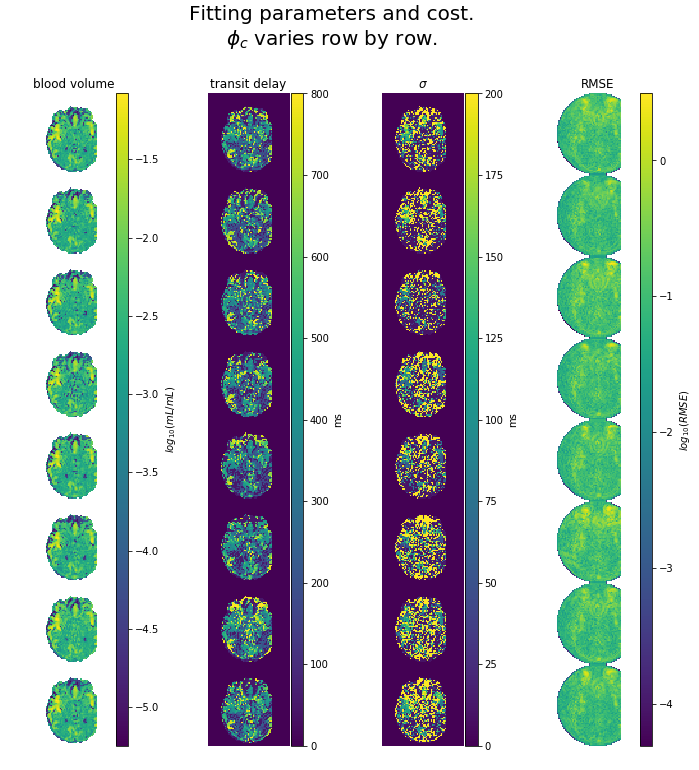

input is  (64, 64, 8, 3)
shape data= (64, 64, 8)
getExtremePhiMap: WIP
getExtremePhiMap: WIP
getExtremePhiMap: WIP
np.shape(phiMap)(64, 64)


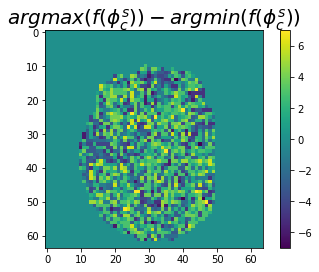

shape abvMat  (64, 64, 8)
shape deltaPhi  (64, 64)
plotCompPanel got cbfMat size (64, 64)


/home/rbussell/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/home/rbussell/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log10
/home/rbussell/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in log10


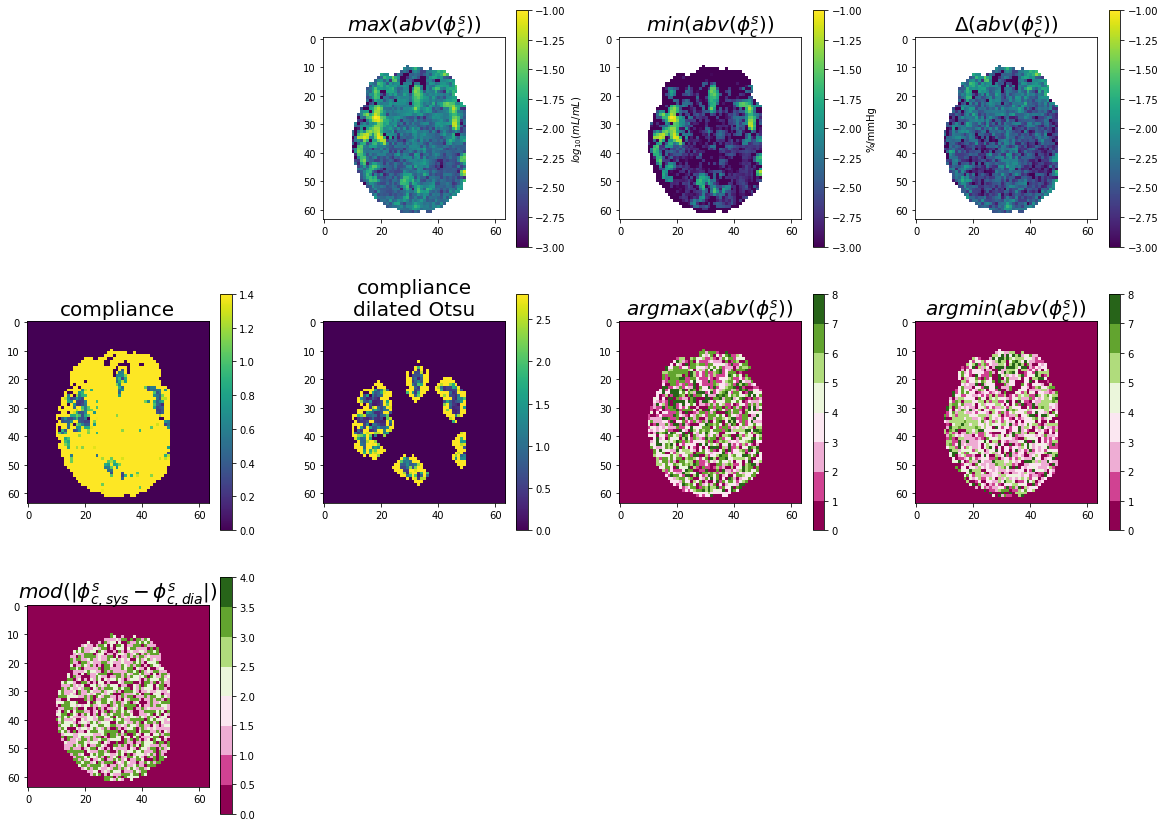

In [13]:
%matplotlib inline
nX=64;nY=64;nBins=8;nPars=3
curSlice=4
procSubDir='vremoteproc/7TIs/m0/'

fitMask=np.load(subDir+'/fitMask.npy')

fitFn=subDir+'/'+procSubDir+'fitB_slice'+str(curSlice)+'_partial.npy'
fitVec=np.load(fitFn)

fitVec=np.tile(fitMask[:,:,curSlice,np.newaxis,np.newaxis],(1,1,1,8,3))*(np.reshape(fitVec,(nX,nY,nBins,nPars)))

mseFn=subDir+'/'+procSubDir+'fitB_slice'+str(curSlice)+'_partial_mse.npy'
mseVec=np.load(mseFn)
mseMat=np.reshape(mseVec,(nX,nY,nBins))

mseMat=np.tile(fitMask[:,:,curSlice,np.newaxis],(1,1,nBins))*mseMat

plot2DFitMatBinLocal(fitVec,mseMat,nX=64,nY=64,nBins=8,fitMatType=1)

#fitVec=np.load('data/fits/v2.0_c4351baae/fitB_slice5.npy')
pp=30
#M0=39.26
#print(np.shape(fitVec))

fitMat3Par=np.reshape(fitVec,(nX,nY,nBins,3))
fitMat3Par=np.transpose(fitMat3Par,(1,0,2,3))

cbfMap=np.zeros((64,64))

abvMat=calcAbvMatB(fitMat3Par,alpha=1,M0=M0)
compMat,abvMaxMat,abvMinMat,abvMaxIdxMat,abvMinIdxMat=calcComp(abvMat,tiVec,phiCSVec,pp=pp,method=3)
plotCompPanelLocal(compMat,abvMaxMat,abvMinMat,abvMaxIdxMat,abvMinIdxMat,mseMat,nPhases=8,abvMaxVal=1,compMaxVal=1.4,cbfMap=cbfMap)